In [ ]:
# Monta google drive
# from google.colab import drive
# drive.mount('/content/drive')

## 1. Carregamento dos dados e importação das bibliotecas

In [ ]:
# Carrega os pacotes necessários
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
#import seaborn as sns

# Importa bibliotecas
#from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, confusion_matrix
#from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
#from imblearn.over_sampling import RandomOverSampler, SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from collections import Counter

# Configurações
pd.set_option('display.max_colwidth', None)

In [ ]:
# Importa os dados
#df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado.json')
df_completo = pd.read_json('./dados/despesa liquidada - base completa - texto processado.json')
df_completo.shape

(37567, 5)

In [ ]:
# Construção de dataframe com as colunas de interesse
df = df_completo[['descricao_lematizada', 'fato_gerador', 'categoria']]
print(df.shape)
df.head()

(37567, 3)


,descricao_lematizada,fato_gerador,categoria
0,despês empenhar controle empenho locacao imovel funcionamento casa apoio equipe tatico metropolitana periodo,Não,Não
1,despês empenhar controle empenho locacao imovel funcionamento arquivo documento inativo deposito material inservivel municipio periodo,Não,Não
2,despês empenhar controle empenho servico eventual prestado atender Secretaria municipal obra transporte mecanico veiculo Secretaria durante,Sim,CI
3,despês empenhar controle empenho servico eventual prestar auxiliar servico geral atender Secretaria Municipal administracao durante dia,Sim,CI
4,despês empenhar controle empenho servico eventual prestado vigia atender Secretaria Municipal administracao durante dia,Sim,CI


## 2. Classificação em 1 etapa (fato gerador e categoria simultaneamente)

In [ ]:
# Separação entre variáveis preditoras e alvo e divisão em treino e teste
X = df['descricao_lematizada']
y = df['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [ ]:
# treinar modelo
pipeline = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', LogisticRegression(solver='saga', max_iter=3000, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=3000, random_state=42,
                                    solver='saga'))])

              precision    recall  f1-score   support

          CA       0.99      0.90      0.94       330
          CI       0.99      1.00      0.99      8478
         Não       0.99      0.99      0.99      2362
          SE       0.99      0.85      0.91       101

    accuracy                           0.99     11271
   macro avg       0.99      0.93      0.96     11271
weighted avg       0.99      0.99      0.99     11271



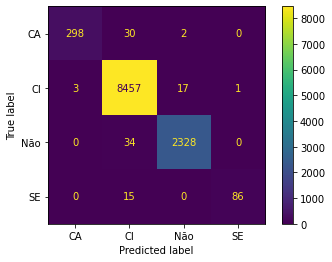

In [ ]:
# gerar estatisticas do conjunto de teste
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
# Salvar o modelo
import joblib
#joblib.dump(pipeline,'/content/drive/My Drive/projeto classificacao de lancamento/modelos/app_modelo.pkl')
joblib.dump(pipeline,'./modelos/app_modelo.pkl')


['./modelos/app_modelo.pkl']

# 3.Testar Modelo

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /home/marcos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/marcos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/marcos/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Importação bibioteca, download e carregamento do modelo 'pt_core_news_sm'
import spacy
spacy.cli.download("pt_core_news_sm")
nlp = spacy.load('pt_core_news_sm')

✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
data = 'Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.'
data

'Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.'

In [ ]:
# Stopwords da biblioteca nltk em português
stop_words_nltk = stopwords.words('portuguese')

# Meses
meses = ['janeiro', 'fevereiro', 'março', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

# Stopwords específicas do corpus
corpus_stop_words = ['cameta', 'portel', 'laranjal', 'jari', 'garrafão', 'concordia', 'zona', 'rural', 'belém', 'pacaja', 'pacajar', 'anapu',
                     'aluno', 'mês', 'serviços', 'servicos', 'referente', 'prestados', 'prestados', 'pagamento', 'municipal', 'município', 'valor', 'empenha',
                     'favor', 'credor', 'acima', 'ocorrer', 'secretaria', 'ensino', 'mes', 'mês', 'durante', 'junto', 'atender', 'periodo', 'ref', 'm', '``']

stop_words = stop_words_nltk + meses + corpus_stop_words
dfwo = pd.DataFrame(stop_words)
dfwo.to_json('./dados/stop_words.json')

In [ ]:
# Função para limpeza de texto
def limpa_texto(text, stop_words=[]):
    # Substitui sinais de pontuação por espaço em branco
    text = text.replace('.', ' ')
    text = text.replace(',', ' ')
    text = text.replace(';', ' ')
    text = text.replace(':', ' ')
    text = text.replace('!', ' ')
    text = text.replace('?', ' ')
    text = text.replace('(', ' ')
    text = text.replace(')', ' ')
    text = text.replace('[', ' ')
    text = text.replace(']', ' ')
    text = text.replace('{', ' ')
    text = text.replace('}', ' ')
    text = text.replace('/', ' ')
    text = text.replace('-', ' ')
    text = re.sub(r'[^\w\s]', '', text)
    text = ''.join(word for word in text if not word.isdigit()).lower()         # remove números e coloca em minúscula
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]                # stopwords
    return ' '.join(tokens)

In [ ]:
# Função de lematização com spaCy
def lematiza_spacy(texto):
    doc = nlp(texto)
    palavras_lemmatizadas = [token.lemma_ for token in doc]
    return ' '.join(palavras_lemmatizadas)

In [ ]:
texto_limpo = limpa_texto(data, stop_words)
texto_limpo

'locacao imovel funcionamento casa apoio equipe tatico metropolitana'

In [ ]:
data = lematiza_spacy(texto_limpo)
data = [data]

In [ ]:
# Fazer a predição usando o modelo treinado
prediction = pipeline.predict(data)

# Mostrar probabilidades
prediction_proba = pipeline.predict_proba(data)

# Mostrar lista de classes e probabilidades num dataframea
df_classes = pd.DataFrame(prediction_proba, columns=pipeline.classes_)
df_classes


,CA,CI,Não,SE
0,0.000933,0.003103,0.995594,0.00037


### OBS ocorre erro no joblib quando as linhas abaixo estao habilitadas, pois nao salva objetos com lambda
    ('over', RandomOverSampler(sampling_strategy=lambda y: ratio_multiplier(y, over_multiplier), random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy=lambda y: ratio_multiplier(y, under_multiplier), random_state=42)),